# INSTALL REQUIREMENTS

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 14.5 MB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 
     |████████████████████████████████| 895 kB 77.0 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 596 kB 68.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 14.8 MB/s 


In [3]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 14.6 MB/s 
     |████████████████████████████████| 181 kB 80.1 MB/s 
     |████████████████████████████████| 144 kB 81.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b4e8a88e43cc2052223216ae453f866949ee20536bbb138b678d61c6d2c6a2f3
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# GOOGLE MOUNT

In [4]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Colab Notebooks/project1/datasets'

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/project1

/content/drive/MyDrive/Colab Notebooks/project1


In [6]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/project1'

# IMPORT REQUIREMENTS

In [7]:
import os
import sys
import random
import pickle

import numpy as np
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence

from transformers import (
    AdamW
)

import wandb

from compute import compute_acc
from visualize_score import plot_graph
from dump_datasets import mk_dataset, mk_dataset_xlnet
from dump_models import load_model, load_model_xlnet
from evaluate import test_model

#CREATE FOLDER

In [8]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
 
createFolder('./best_models')
createFolder('./dump_datasets')
createFolder('./dump_models_tokenizer')
createFolder('./scores')
createFolder('./submissions')

# FIX SEED

In [9]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

# MODEL

In [10]:
MODEL_NAME = 'bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME = 'xlnet-base-cased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert str(device) == 'cuda'

try:
    with open('./dump_models_tokenizer/' + MODEL_NAME + '.p', 'rb') as f:
        model = pickle.load(f)
        tokenizer = pickle.load(f)
        print('./dump_models_tokenizer/' + MODEL_NAME + '.p')
    print('model exists => just load model')
except:
    print('exeption occur => download model')
    if MODEL_NAME == 'bert-base-uncased':
        model, tokenizer = load_model(MODEL_NAME)
    elif MODEL_NAME == 'xlnet-base-cased':
        model, tokenizer = load_model_xlnet(MODEL_NAME)

model.to(device)

exeption occur => download model


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# HYPER PARAMETERS

In [11]:
TRAIN_BATCH_SIZE=256
EVAL_BATCH_SIZE=256

LEARNING_RATE = 5e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
TRAIN_EPOCH = 3

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
wandb.init(project="test-project", entity="goorm_team_2")

RUNNAME = 'bert_ep3' + str(LEARNING_RATE)
wandb.run.name = RUNNAME
wandb.config.learning_rate = LEARNING_RATE
wandb.config.epochs = TRAIN_EPOCH

wandb.config = {
   "learning_rate": LEARNING_RATE,
   "epochs": TRAIN_EPOCH,
   "batch_size": TRAIN_BATCH_SIZE
 }
# ########################################
# sweep_config = {'method': 'random'}
# metric = {'name': 'loss',
#     'goal': 'minimize'}
# sweep_config['metric'] = metric
# #########################################
# parameters_dict = {'optimizer': {'values': ['adam', 'sgd']},
#                    'fc_layer_size': {'values': [128, 256, 512]},
#                    'dropout': {'values': [0.3, 0.4, 0.5]},}
# sweep_config['parameters'] = parameters_dict
# #####################################
# parameters_dict.update({
#     'epochs': {
#         'value': 1}
#     })
# #####################################
# import math
# parameters_dict.update({'learning_rate': {'distribution': 'uniform', 'min': 0, 'max': 0.1}, # a flat distribution between 0 and 0.1
#                         'batch_size': {'distribution': 'q_log_uniform', 'q': 1, 'min': math.log(32), 'max': math.log(256),}})   # integers between 32 and 256 with evenly-distributed logarithms
# #####################################
# sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# LOAD DATASETS

In [13]:
try:
    if  MODEL_NAME == 'bert-base-uncased':
        with open('./dump_datasets/train_dev_dumps.p', 'rb') as f:
            train_pos = pickle.load(f)
            train_neg = pickle.load(f)
            dev_pos = pickle.load(f)
            dev_neg = pickle.load(f)
        print('dataset exists => just load datasets')
    elif  MODEL_NAME == 'xlnet-base-cased':
        with open('./dump_datasets/train_dev_dumps_xlnet.p', 'rb') as f:
            train_pos = pickle.load(f)
            train_neg = pickle.load(f)
            dev_pos = pickle.load(f)
            dev_neg = pickle.load(f)
        print('dataset exists => just load datasets')
except:
    print('exeption occur => make datasets')
    train_pos, train_neg, dev_pos, dev_neg = mk_dataset()
    if MODEL_NAME == 'bert-base-uncased':
        train_pos, train_neg, dev_pos, dev_neg = mk_dataset()
    elif MODEL_NAME == 'xlnet-base-cased':
        train_pos, train_neg, dev_pos, dev_neg = mk_dataset_xlnet()

exeption occur => make datasets


# DATA PREPROCESSING

In [ ]:
'''
전처리
'''

'\n전처리\n'

# TOKENIZE

In [14]:
train_pos = [tokenizer.encode(line) for line in train_pos]
train_neg = [tokenizer.encode(line) for line in train_neg]
dev_pos = [tokenizer.encode(line) for line in dev_pos]
dev_neg = [tokenizer.encode(line) for line in dev_neg]

# MAKE DATASETS

In [15]:
class SentimentDataset(object):
    def __init__(self, pos, neg):
        self.data = [pos_sent for pos_sent in pos] + [neg_sent for neg_sent in neg]
        self.label = [[1] for _ in range(len(pos))] + [[0] for _ in range(len(neg))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

train_dataset = SentimentDataset(train_pos, train_neg)
dev_dataset = SentimentDataset(dev_pos, dev_neg)

# DATA LOADER

In [ ]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)

    attention_mask = torch.tensor([[1] * len(input_id) + [0] * (max_len - len(input_id)) for input_id in input_ids])
    input_ids = pad_sequence([torch.tensor(input_id) for input_id in input_ids], batch_first=True)
    token_type_ids = torch.tensor([[0] * len(input_id) for input_id in input_ids])
    position_ids = torch.tensor([list(range(len(input_id))) for input_id in input_ids])
    labels = torch.tensor(np.stack(labels, axis=0))

    return input_ids, attention_mask, token_type_ids, position_ids, labels

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True, 
                                           collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)

dev_loader = torch.utils.data.DataLoader(dev_dataset, 
                                         batch_size=EVAL_BATCH_SIZE,
                                         shuffle=False, 
                                         collate_fn=collate_fn_style,
                                         num_workers=2)

# TRAIN

In [ ]:
lowest_valid_loss = 9999.
highest_valid_acc = 0.
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []

temp_train_acc = []
temp_train_loss = []

model.train()
for epoch in range(TRAIN_EPOCH):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):

            tepoch.set_description(f"Epoch {epoch}")

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            
            logits = output.logits
            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
            batch_labels = [int(example) for example in labels]
            
            acc = compute_acc(batch_predictions, batch_labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            tepoch.set_postfix(acc=acc, loss=loss.item())
            
            temp_train_acc.append(acc)
            temp_train_loss.append(loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 100) == 0:

                model.eval()
                with torch.no_grad():
                    val_acc = []
                    val_loss = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in dev_loader:
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids,
                                    position_ids=position_ids,
                                    labels=labels)

                        logits = output.logits
                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        val_acc.append(compute_acc(batch_predictions, batch_labels))
                        val_loss.append(output.loss)

                mean_train_acc = sum(temp_train_acc) / len(temp_train_acc)
                mean_train_loss = sum(temp_train_loss) / len(temp_train_loss)
                mean_val_acc = sum(val_acc) / len(val_acc)
                mean_val_loss = sum(val_loss) / len(val_loss)

                train_acc.append(mean_train_acc)
                train_loss.append(mean_train_loss)
                valid_acc.append(mean_val_acc)
                valid_loss.append(mean_val_loss)

                temp_train_acc = []
                temp_train_loss = []
                
                # WANDB
                wandb.log({"train_loss": mean_train_loss,
                           'train_acc': mean_train_acc,
                           'valid_loss': mean_val_loss,
                           'valid_acc': mean_val_acc})

                if highest_valid_acc < mean_val_acc:
                    highest_valid_acc = mean_val_acc
                    print('ACCURACY for highest valid acc: ', mean_val_acc)
                    print('LOSS for lowest valid acc: ', mean_val_loss)
                    # model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)))

                elif lowest_valid_loss > mean_val_loss:
                    lowest_valid_loss = mean_val_loss
                    print('ACCURACY for lowest valid loss: ', mean_val_acc)
                    print('LOSS for lowest valid loss: ', mean_val_loss)
                    # model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)))
                                        
                model.train()
model.save_pretrained('./best_models/model' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)))

Epoch 0:   1%|          | 18/1732 [00:12<39:57,  1.40s/batch, acc=0.926, loss=0.177]

ACCURACY for highest valid acc:  0.94462890625
LOSS for lowest valid acc:  tensor(0.1564, device='cuda:0')


Epoch 0:   2%|▏         | 35/1732 [00:24<40:01,  1.42s/batch, acc=0.965, loss=0.104]

ACCURACY for highest valid acc:  0.96220703125
LOSS for lowest valid acc:  tensor(0.1072, device='cuda:0')


Epoch 0:   3%|▎         | 52/1732 [00:36<39:04,  1.40s/batch, acc=0.941, loss=0.156]

ACCURACY for highest valid acc:  0.96396484375
LOSS for lowest valid acc:  tensor(0.1071, device='cuda:0')


Epoch 0:   4%|▍         | 69/1732 [00:47<39:11,  1.41s/batch, acc=0.977, loss=0.0929]

ACCURACY for lowest valid loss:  0.959130859375
LOSS for lowest valid loss:  tensor(0.1098, device='cuda:0')


Epoch 0:   5%|▍         | 86/1732 [00:59<38:11,  1.39s/batch, acc=0.965, loss=0.0904]

ACCURACY for highest valid acc:  0.96962890625
LOSS for lowest valid acc:  tensor(0.0884, device='cuda:0')


Epoch 0:   6%|▌         | 103/1732 [01:11<38:08,  1.40s/batch, acc=0.941, loss=0.163]

ACCURACY for highest valid acc:  0.9708984375
LOSS for lowest valid acc:  tensor(0.0855, device='cuda:0')


Epoch 0:   7%|▋         | 120/1732 [01:23<37:36,  1.40s/batch, acc=0.977, loss=0.0503]

ACCURACY for lowest valid loss:  0.966552734375
LOSS for lowest valid loss:  tensor(0.1005, device='cuda:0')


Epoch 0:   8%|▊         | 137/1732 [01:35<37:36,  1.41s/batch, acc=0.961, loss=0.14]

ACCURACY for highest valid acc:  0.973193359375
LOSS for lowest valid acc:  tensor(0.0855, device='cuda:0')


Epoch 0:   9%|▉         | 154/1732 [01:46<36:55,  1.40s/batch, acc=0.949, loss=0.0996]

ACCURACY for lowest valid loss:  0.967919921875
LOSS for lowest valid loss:  tensor(0.0871, device='cuda:0')


Epoch 0:  11%|█         | 188/1732 [02:10<37:17,  1.45s/batch, acc=0.969, loss=0.114]

ACCURACY for lowest valid loss:  0.969775390625
LOSS for lowest valid loss:  tensor(0.0824, device='cuda:0')


Epoch 0:  14%|█▍        | 239/1732 [02:46<34:56,  1.40s/batch, acc=0.98, loss=0.0791]

ACCURACY for lowest valid loss:  0.972998046875
LOSS for lowest valid loss:  tensor(0.0749, device='cuda:0')


Epoch 0:  15%|█▍        | 256/1732 [02:57<34:24,  1.40s/batch, acc=0.984, loss=0.0454]

ACCURACY for highest valid acc:  0.973583984375
LOSS for lowest valid acc:  tensor(0.0732, device='cuda:0')


Epoch 0:  16%|█▌        | 273/1732 [03:09<33:51,  1.39s/batch, acc=0.988, loss=0.0304]

ACCURACY for highest valid acc:  0.97470703125
LOSS for lowest valid acc:  tensor(0.0712, device='cuda:0')


Epoch 0:  17%|█▋        | 290/1732 [03:21<33:40,  1.40s/batch, acc=0.984, loss=0.0644]

ACCURACY for lowest valid loss:  0.97099609375
LOSS for lowest valid loss:  tensor(0.0733, device='cuda:0')


Epoch 0:  18%|█▊        | 307/1732 [03:33<33:12,  1.40s/batch, acc=0.984, loss=0.0818]

ACCURACY for lowest valid loss:  0.974560546875
LOSS for lowest valid loss:  tensor(0.0723, device='cuda:0')


Epoch 0:  20%|█▉        | 341/1732 [03:56<32:18,  1.39s/batch, acc=0.977, loss=0.0467]

ACCURACY for lowest valid loss:  0.97333984375
LOSS for lowest valid loss:  tensor(0.0683, device='cuda:0')


Epoch 0:  23%|██▎       | 392/1732 [04:32<31:56,  1.43s/batch, acc=0.973, loss=0.121]

ACCURACY for highest valid acc:  0.9748046875
LOSS for lowest valid acc:  tensor(0.0714, device='cuda:0')


Epoch 0:  26%|██▌       | 443/1732 [05:08<30:24,  1.42s/batch, acc=0.98, loss=0.0525]

ACCURACY for highest valid acc:  0.97578125
LOSS for lowest valid acc:  tensor(0.0651, device='cuda:0')


Epoch 0:  28%|██▊       | 477/1732 [05:32<29:26,  1.41s/batch, acc=0.969, loss=0.0776]

ACCURACY for highest valid acc:  0.97626953125
LOSS for lowest valid acc:  tensor(0.0650, device='cuda:0')


Epoch 0:  29%|██▊       | 494/1732 [05:44<29:36,  1.43s/batch, acc=0.973, loss=0.0593]

ACCURACY for highest valid acc:  0.97666015625
LOSS for lowest valid acc:  tensor(0.0741, device='cuda:0')


Epoch 0:  30%|██▉       | 511/1732 [05:56<28:59,  1.42s/batch, acc=0.969, loss=0.0906]

ACCURACY for lowest valid loss:  0.975439453125
LOSS for lowest valid loss:  tensor(0.0624, device='cuda:0')


Epoch 0:  32%|███▏      | 562/1732 [06:32<27:12,  1.40s/batch, acc=0.988, loss=0.0568]

ACCURACY for highest valid acc:  0.977978515625
LOSS for lowest valid acc:  tensor(0.0655, device='cuda:0')


Epoch 0:  42%|████▏     | 732/1732 [08:30<23:27,  1.41s/batch, acc=0.977, loss=0.0532]

ACCURACY for lowest valid loss:  0.977880859375
LOSS for lowest valid loss:  tensor(0.0608, device='cuda:0')


Epoch 0:  48%|████▊     | 834/1732 [09:41<21:11,  1.42s/batch, acc=0.984, loss=0.0381]

ACCURACY for highest valid acc:  0.97822265625
LOSS for lowest valid acc:  tensor(0.0636, device='cuda:0')


Epoch 0:  54%|█████▍    | 936/1732 [10:53<18:50,  1.42s/batch, acc=0.988, loss=0.0334]

ACCURACY for highest valid acc:  0.9783203125
LOSS for lowest valid acc:  tensor(0.0609, device='cuda:0')


Epoch 0:  63%|██████▎   | 1089/1732 [12:40<15:00,  1.40s/batch, acc=0.977, loss=0.0634]

ACCURACY for lowest valid loss:  0.97822265625
LOSS for lowest valid loss:  tensor(0.0606, device='cuda:0')


Epoch 0:  65%|██████▍   | 1123/1732 [13:03<14:12,  1.40s/batch, acc=0.988, loss=0.0341]

ACCURACY for lowest valid loss:  0.977978515625
LOSS for lowest valid loss:  tensor(0.0571, device='cuda:0')


Epoch 0:  67%|██████▋   | 1157/1732 [13:27<13:22,  1.40s/batch, acc=0.969, loss=0.0814]

ACCURACY for highest valid acc:  0.979443359375
LOSS for lowest valid acc:  tensor(0.0600, device='cuda:0')


Epoch 0:  75%|███████▍  | 1293/1732 [15:02<10:21,  1.42s/batch, acc=0.969, loss=0.0801]

ACCURACY for highest valid acc:  0.980322265625
LOSS for lowest valid acc:  tensor(0.0598, device='cuda:0')


Epoch 0:  76%|███████▌  | 1310/1732 [15:14<09:54,  1.41s/batch, acc=0.969, loss=0.0838]

ACCURACY for highest valid acc:  0.9810546875
LOSS for lowest valid acc:  tensor(0.0560, device='cuda:0')


Epoch 0:  81%|████████  | 1395/1732 [16:13<07:52,  1.40s/batch, acc=0.988, loss=0.0352]

ACCURACY for lowest valid loss:  0.980224609375
LOSS for lowest valid loss:  tensor(0.0570, device='cuda:0')


Epoch 0:  82%|████████▏ | 1412/1732 [16:25<07:26,  1.40s/batch, acc=0.988, loss=0.0348]

ACCURACY for lowest valid loss:  0.97998046875
LOSS for lowest valid loss:  tensor(0.0562, device='cuda:0')


Epoch 0:  83%|████████▎ | 1429/1732 [16:37<07:07,  1.41s/batch, acc=0.973, loss=0.0573]

ACCURACY for lowest valid loss:  0.97998046875
LOSS for lowest valid loss:  tensor(0.0547, device='cuda:0')


Epoch 0:  83%|████████▎ | 1446/1732 [16:49<06:40,  1.40s/batch, acc=0.98, loss=0.0555]

ACCURACY for lowest valid loss:  0.98046875
LOSS for lowest valid loss:  tensor(0.0533, device='cuda:0')


Epoch 0:  84%|████████▍ | 1463/1732 [17:01<06:24,  1.43s/batch, acc=0.98, loss=0.0388]

ACCURACY for lowest valid loss:  0.980224609375
LOSS for lowest valid loss:  tensor(0.0522, device='cuda:0')


Epoch 0:  89%|████████▉ | 1548/1732 [18:00<04:19,  1.41s/batch, acc=0.984, loss=0.0525]

ACCURACY for highest valid acc:  0.982177734375
LOSS for lowest valid acc:  tensor(0.0527, device='cuda:0')


Epoch 1:   7%|▋         | 120/1732 [01:23<37:44,  1.41s/batch, acc=0.984, loss=0.0348]

ACCURACY for highest valid acc:  0.9833984375
LOSS for lowest valid acc:  tensor(0.0539, device='cuda:0')


Epoch 1:   8%|▊         | 137/1732 [01:35<38:13,  1.44s/batch, acc=0.988, loss=0.03]

ACCURACY for highest valid acc:  0.983642578125
LOSS for lowest valid acc:  tensor(0.0547, device='cuda:0')


Epoch 2: 100%|██████████| 1732/1732 [20:06<00:00,  1.44batch/s, acc=0.992, loss=0.0186]


# SAVE SCORES

In [ ]:
accloss_filename = 'accloss' + str(int(mean_val_acc*100)) + str(int(mean_val_loss*1000)) + '.p'
with open('./scores/' + accloss_filename,'wb') as f:
    pickle.dump(train_acc, f)
    pickle.dump(train_loss, f)
    pickle.dump(valid_acc, f)
    pickle.dump(valid_loss, f)

# TEST

In [ ]:
test_model(model, tokenizer, mean_val_acc, mean_val_loss, file_name = 'test_no_label', device='cuda')

(tensor([[  101,  2009,  1005,  ...,   102,     0,     0],
        [  101,  2061, 15640,  ...,     0,     0,     0],
        [  101,  2009,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  3835,  4989,  ...,     0,     0,     0],
        [  101,  2027,  2031,  ...,     0,     0,     0],
        [  101,  2023,  2003,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[ 0,  1,  2,  ..., 16, 17, 18],
        [ 0,  1,  2,  ..., 16, 17, 18],
        [ 0,  1,  2,  ..., 16, 17, 18],
        ...,
        [ 0,  1,  2,  ..., 16, 17, 18],
        [ 0,  1,  2,  ...


Test:  88%|████████▊ | 14/16 [00:00<00:00, 18.61it/s]
                                                     

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 

# SCORE VISUALIZE

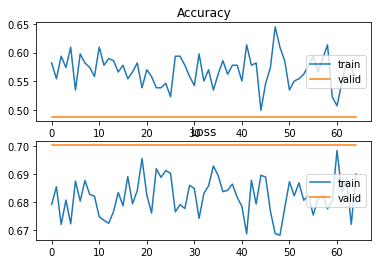

In [ ]:
plot_graph(accloss_filename)